# Chapter 3 Deep Learning (2) CNN - Visualization (PyTorch)
- Grad-CAM, Saliency, Feature-map visualization using PyTorch/torchvision

In [72]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

# load pretrained model (e.g., ResNet18)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
model.eval()

# transforms for ImageNet models
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

device: cuda


In [73]:
# helper: load image path -> tensor
IM_PATH = None  # set a local image path or use a sample from torchvision

imagenet_classes = models.ResNet18_Weights.DEFAULT.meta['categories']

def load_image(path):
    img = Image.open(path).convert('RGB')
    return preprocess(img).unsqueeze(0).to(device)

@torch.no_grad()
def predict(img_t):
    logits = model(img_t)
    probs = logits.softmax(dim=1)[0].cpu().numpy()
    top5_idx = probs.argsort()[-5:][::-1]
    return logits, probs, top5_idx

Search for Sample Image from:  
https://unsplash.com/

Top-5 predictions:
[('dining table', 0.511965274810791), ('restaurant', 0.07473810017108917), ('sliding door', 0.04566100239753723), ('table lamp', 0.04428448900580406), ('desk', 0.026539746671915054)]
Corresponding index: [532 762 799 846 526]


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

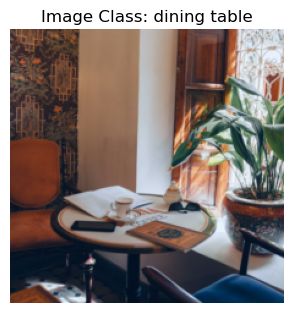

In [74]:
import urllib.request
sample_url = 'https://images.unsplash.com/photo-1760681557777-bfac1f18cf90?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&q=80&w=2070'
IM_PATH = 'data/sample.jpg'
urllib.request.urlretrieve(sample_url, IM_PATH)

img_t = load_image(IM_PATH)
rgb_float = img_t[0,:,:,:].permute(1,2,0).cpu().numpy()
rgb_float = (rgb_float - rgb_float.min()) / (rgb_float.max() - rgb_float.min()) # Normalize to [0,1]

print('Top-5 predictions:')
logits, probs, top5_idx = predict(img_t)
print([(imagenet_classes[i], float(probs[i])) for i in top5_idx])
print('Corresponding index:', top5_idx)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(rgb_float); 
plt.title(f'Image Class: {imagenet_classes[top5_idx[0]]}'); plt.axis('off')

# Define Target Layer

In [75]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [76]:
# target layer for Grad-CAM (use last BasicBlock of layer4)
# pytorch-grad-cam examples recommend the last conv-containing block
target_layer = model.layer4[-1]
target_layer

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Grad-CAM (PyTorch)

In [77]:
try:
    import pytorch_grad_cam
except ImportError:
    !pip install pytorch-grad-cam

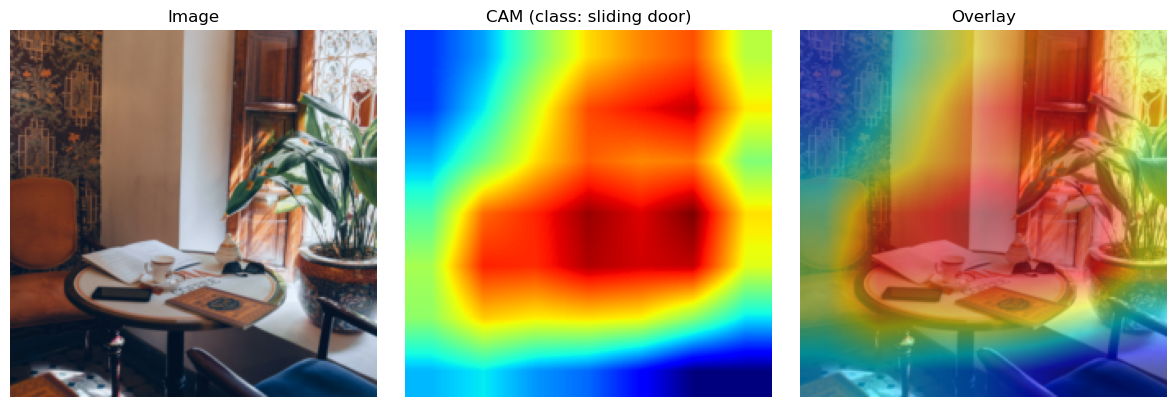

In [78]:
# Grad-CAM via pytorch-grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

cam = GradCAM(model=model, target_layers=[target_layer])

##################################  Try to change the idx #############################
idx = 2
cls_idx = top5_idx[idx]  
########################################################################################

grayscale_cam = cam(input_tensor=img_t, targets=[ClassifierOutputTarget(cls_idx)])[0]
vis = show_cam_on_image(rgb_float, grayscale_cam, use_rgb=True)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(rgb_float); plt.title('Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(grayscale_cam, cmap='jet'); plt.title(f'CAM (class: {imagenet_classes[cls_idx]})'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(vis); plt.title('Overlay'); plt.axis('off')
plt.tight_layout(); plt.show()

## Feature map visualization (early conv layers)

Feature map shape (conv1): torch.Size([64, 56, 56])


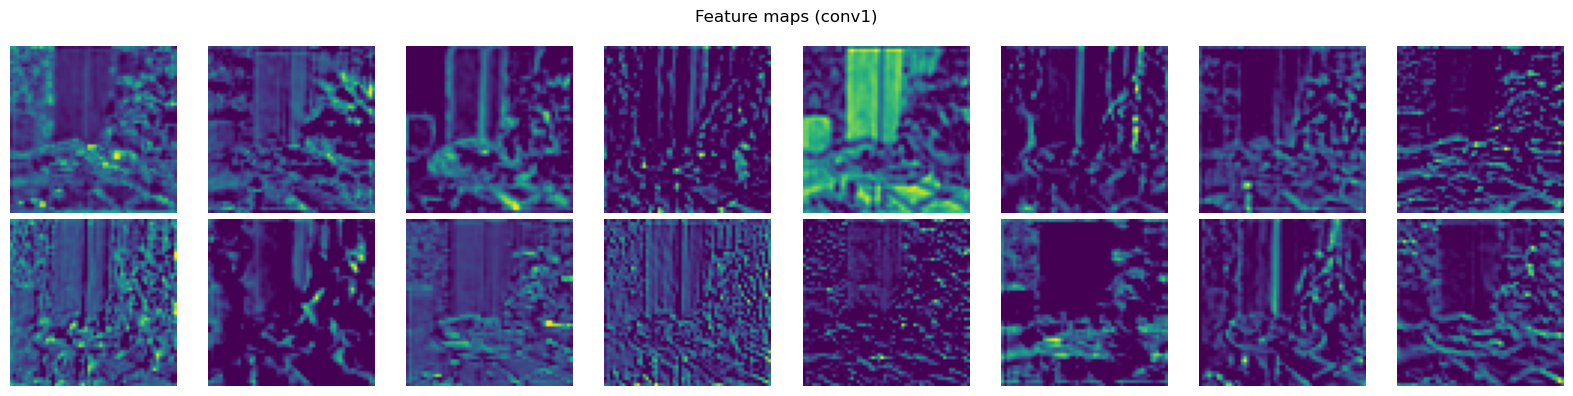

In [80]:
##################################  Try to change the layer # #############################
# conv_visualization = model.conv1
conv_visualization = model.layer1
########################################################################################

feat_acts = []
h = conv_visualization.register_forward_hook(lambda m, i, o: feat_acts.append(o.detach().cpu())) # m: module, i: input, o: output
_ = model(img_t)
h.remove()
fm = feat_acts[-1][0]  # CxHxW

print('Feature map shape (conv1):', fm.shape)  # C x H x W

# plot first 16 channels
k = min(16, fm.shape[0])
cols = 8
rows = int(np.ceil(k/cols))
plt.figure(figsize=(2*cols, 2*rows))
for i in range(k):
    plt.subplot(rows, cols, i+1)
    ch = fm[i]
    ch = (ch - ch.min()) / (ch.max() - ch.min() + 1e-8)
    plt.imshow(ch, cmap='viridis')
    plt.axis('off')
plt.suptitle('Feature maps (conv1)'); plt.tight_layout(); plt.show()